In [1]:
!pip install gdcm
!pip install fastbook
!pip install pylibjpeg-libjpeg
!pip install pylibjpeg

     |████████████████████████████████| 2.7 MB 28.6 MB/s eta 0:00:01
     |████████████████████████████████| 720 kB 27.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 29.1 MB/s eta 0:00:01


In [1]:
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai.imports import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = Path('./New Data/train-Data/train/')

In [3]:
class PILDicom2(PILBase):
    _open_args,_tensor_cls,_show_args = {},TensorDicom,TensorDicom._show_args
    @classmethod
    def create(cls, fn:(Path,str,bytes), mode=None)->None:
        if isinstance(fn,bytes): 
            im = pydicom.dcmread(pydicom.filebase.DicomBytesIO(fn))
        if isinstance(fn,(Path,str)): 
            im = fn.dcmread()
        scaled = np.array(im.windowed(w=1500, l=-600).numpy())*255
        scaled = scaled.astype(np.uint8)
        return cls(Image.fromarray(scaled))

In [4]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILDicom2), CategoryBlock),
    get_items=get_dicom_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(512)],
    batch_tfms=aug_transforms(size=512)
    )

In [5]:
dls = dblock.dataloaders(path, bs = 16, num_workers=0)

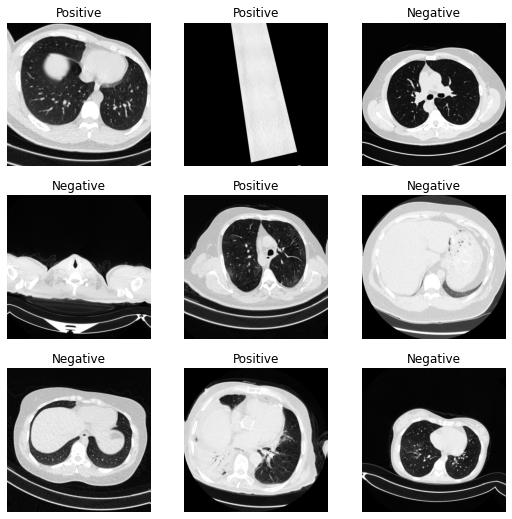

In [6]:
dls.train.show_batch(max_n=9, nrows=3)

In [7]:
len(dls.train_ds), len(dls.valid_ds)

(11378, 2844)

In [8]:
mixup = MixUp(0.5)

In [9]:
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=[accuracy, 
                    Precision(), Recall(), F1Score()], cbs = mixup)

In [10]:
learn.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

SuggestedLRs(valley=0.0004786300996784121)

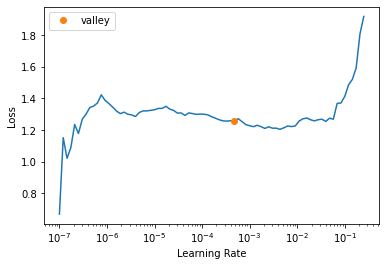

In [11]:
learn.lr_find()

In [12]:
learn.fine_tune(epochs=1,
          base_lr=0.0004786300996784121,
          cbs=[SaveModelCallback(monitor='f1_score')])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.684165,0.449371,0.851617,0.844535,0.865692,0.854983,09:17


Better model found at epoch 0 with f1_score value: 0.8549828178694158.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.509444,0.281733,0.959916,0.957785,0.963118,0.960444,08:19


Better model found at epoch 0 with f1_score value: 0.9604441360166551.


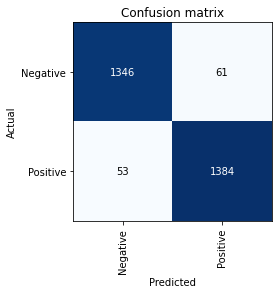

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [14]:
learn.unfreeze()
learn.fit_one_cycle(n_epoch=4, lr_max=0.0004786300996784121)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.569180,0.439156,0.845992,0.825407,0.881698,0.852624,08:17
1,0.501810,0.416987,0.851266,0.840268,0.871260,0.855483,08:21
2,0.444014,0.263752,0.976090,0.979678,0.972860,0.976257,08:16
3,0.428735,0.256468,0.976090,0.979678,0.972860,0.976257,08:18


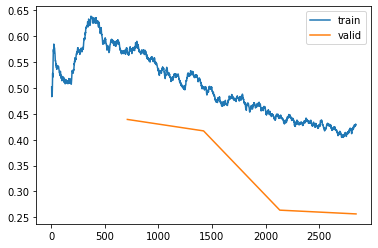

In [15]:
learn.recorder.plot_loss()

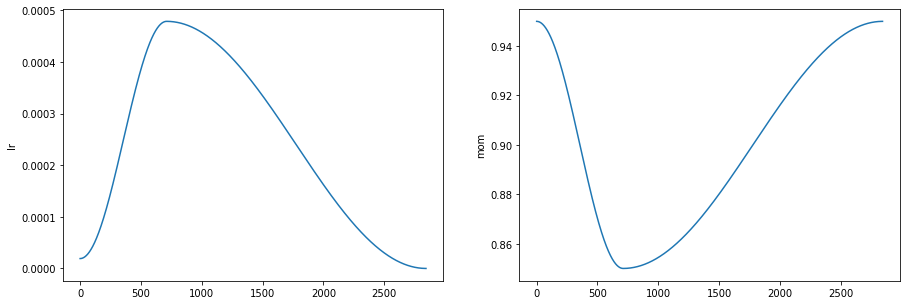

In [16]:
learn.recorder.plot_sched(figsize=(15,5))

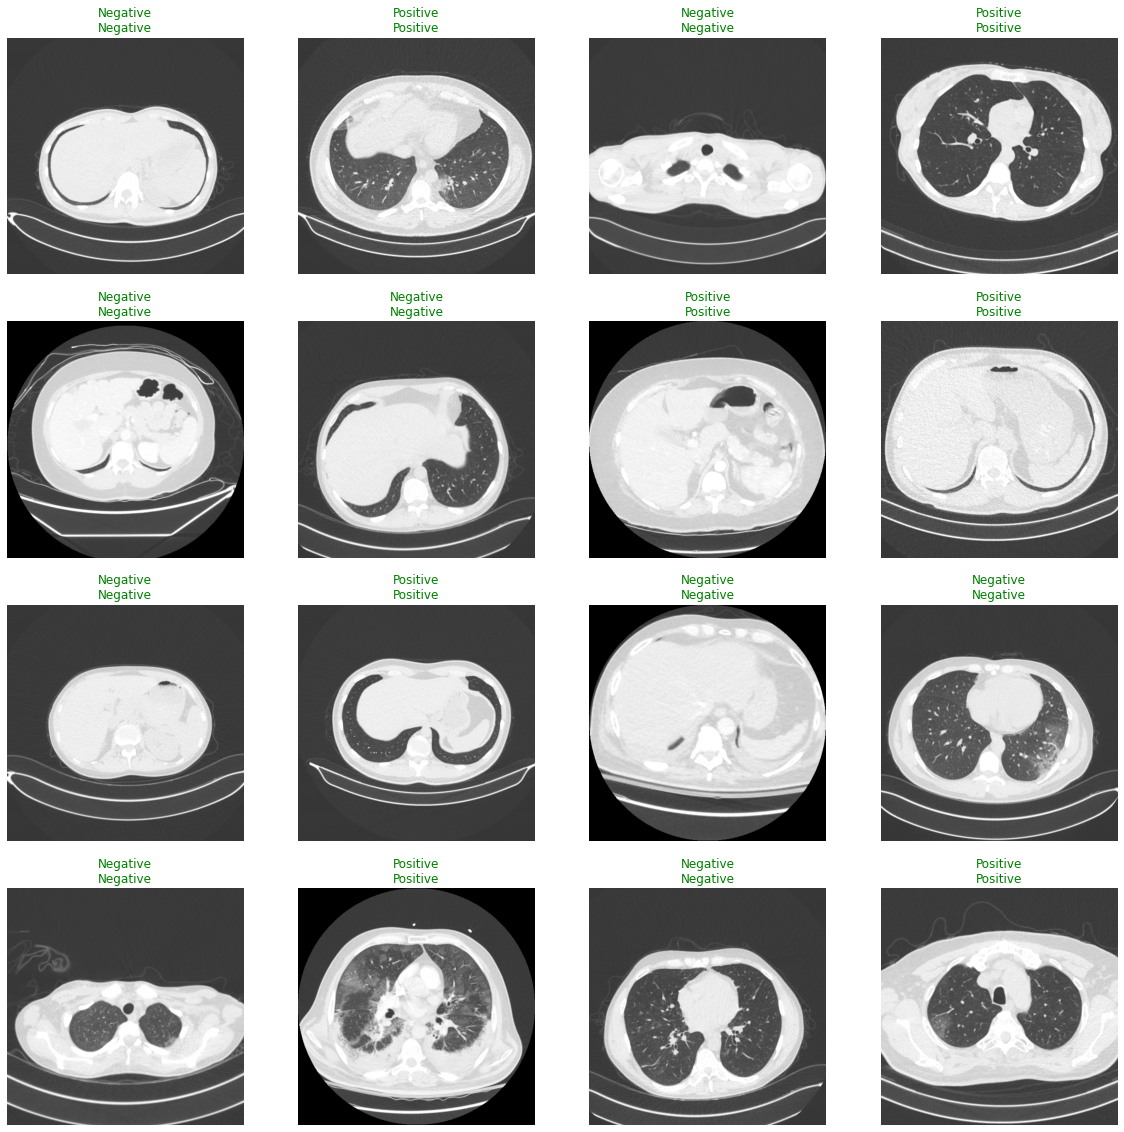

In [17]:
learn.show_results(max_n=16,figsize=(20,20))

In [18]:
test_path = './New Data/test-Data/test/'
test_files = get_dicom_files(test_path)
test_files

(#3406) [Path('New Data/test-Data/test/Negative/2.000000-62502-1-097.dcm'),Path('New Data/test-Data/test/Negative/2.000000-55762-1-023.dcm'),Path('New Data/test-Data/test/Negative/2.000000-57539-1-018.dcm'),Path('New Data/test-Data/test/Negative/2.000000-58080-1-182.dcm'),Path('New Data/test-Data/test/Negative/3.000000-58887-1-108.dcm'),Path('New Data/test-Data/test/Negative/3.000000-56570-1-170.dcm'),Path('New Data/test-Data/test/Negative/3.000000-56570-1-130.dcm'),Path('New Data/test-Data/test/Negative/2.000000-57539-1-162.dcm'),Path('New Data/test-Data/test/Negative/3.000000-60317-1-178.dcm'),Path('New Data/test-Data/test/Negative/3.000000-61865-1-197.dcm')...]

In [19]:
len(test_files)

3406

In [20]:
test_dls = dls.test_dl(test_files, bs = 16, with_labels=True) #holdout set

In [21]:
test_interp = ClassificationInterpretation.from_learner(learn, dl=test_dls)

              precision    recall  f1-score   support

    Negative       0.75      0.70      0.72      2085
    Positive       0.57      0.63      0.60      1321

    accuracy                           0.67      3406
   macro avg       0.66      0.66      0.66      3406
weighted avg       0.68      0.67      0.67      3406



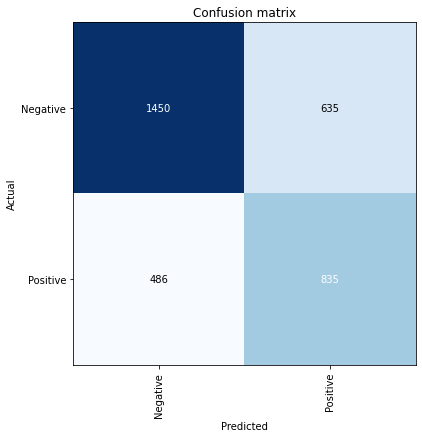

In [22]:
test_interp.print_classification_report()
test_interp.plot_confusion_matrix(figsize=(6,6))

In [23]:
learn.export()

In [26]:
learn.predict(Path('New Data/test-Data/test/Negative/2.000000-62502-1-097.dcm'))

('Negative', TensorBase(0), TensorBase([0.9433, 0.0567]))

In [27]:
learn.predict(Path('New Data/test-Data/test/Negative/3.000000-61865-1-197.dcm'))

('Positive', TensorBase(1), TensorBase([0.2841, 0.7159]))

In [28]:
pos = learn.predict(Path('New Data/test-Data/test/Positive/2.000000-40436-1-001.dcm'))

In [29]:
pos[0]

'Negative'

In [30]:
# checking covid based on average of total images not per image

def covid_check(images_path):
    covid = 0
    no_covid = 0
    patient_images = get_dicom_files(images_path)
    for x in patient_images:
        pred = learn.predict(x)
        if pred[0] == 'Negative':
            no_covid += 1
        else:
            covid += 1
        continue
    if covid > no_covid:
        print('POSITIVE FOR COVID')
    elif covid < no_covid:
        print('NEGATIVE FOR COVID')
    else:
        print('REDO TEST')
    #return covid, no_covid

In [31]:
test_patient1 = './test-normal/set-A/MIDRC-RICORD-1A-660042-000124'

In [32]:
covid_check(test_patient1)

POSITIVE FOR COVID


In [33]:
test_patient2 = './test-normal/set-A/MIDRC-RICORD-1A-660042-000127'
covid_check(test_patient2)

POSITIVE FOR COVID


In [34]:
test_patient3 = './test-normal/set-A/MIDRC-RICORD-1A-660042-000149'
covid_check(test_patient3)

NEGATIVE FOR COVID


In [35]:
test_patient4 = './test-normal/set-B/MIDRC-RICORD-1B-660042-000232'
covid_check(test_patient4)

NEGATIVE FOR COVID


In [36]:
test_patient5 = './test-normal/set-B/MIDRC-RICORD-1B-660042-000256'
covid_check(test_patient5)

NEGATIVE FOR COVID


In [24]:
!nvidia-smi

Fri Feb  4 21:33:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  RTX A4000           Off  | 00000000:00:05.0 Off |                  Off |
| 41%   49C    P8    17W / 140W |   7881MiB / 16117MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#import torch
#torch.cuda.empty_cache()